# 2nd Notebook to Visualize TopoFlow Output

### Table of Contents

1.  <a href="#intro_C">Introduction</a> <br>
2.  <a href="#dirs_C">Create Some Directories in Your Home Directory</a> <br>
3.  <a href="#imports_C">Import Required Python Packages</a> <br>
4.  <a href="#show_rtg_C">Show a Grid from an RTG File</a> <br>
5.  <a href="#show_nc1_C">Show a Grid from Grid Stack in a TF netCDF File</a> <br>
6.  <a href="#show_rts1_C">Show a Grid from Grid Stack in an RTS File</a> <br>
7.  <a href="#stack2im_C">Create a Set of Image Files from a TF Grid Stack</a> <br>
8.  <a href="#ims2movie_C">Make a Movie from a Set of Image Files</a> <br>
9.  <a href="#ts_plot_C">Plot a TF Time Series</a> <br>
10. <a href="#prof_plot_C">Plot One Profile in a Profile Series</a> <br>
11. <a href="#ps_images_C">Create Image Files from a TF Profile Series</a> <br>
12. <a href="#ps_movie_C">Make a Movie from a TF Profile Series</a> <br>
13. <a href="#play_movie_C">Play the Movie in the Notebook</a> <br>
14. <a href="#setup_C">Appendix 1: &nbsp; Set up a conda Environment for this Notebook</a>

<!-- Hyperlink IDs must be unique to work in Jupyter Lab when
there are multiple notebooks open. Hence the trailing letter. -->

## Introduction  <a id="intro_C"></a>

Before you can run the code in this notebook, you will need to install the TopoFlow 3.6 Python package.  This notebook uses new visualization functions from <b>topoflow.utils.visualize.py</b>.  Detailed instructions and background information for how to install TopoFlow in a conda environment are given in
<a href="#setup"><b>Appendix 1:  Installing TopoFlow in a conda Environment</b></a>.

TopoFlow stores values of output variables in multiple file formats, but the main one is netCDF format.  This Jupyter notebook shows how to read values of variables from TopoFlow netCDF output files and to then visualize them.

The TopoFlow model consists of a collection of <b>components</b>, each of which is able to model a particular hydrologic process in a particular way.  It provides a very flexible, <b>plug-and-play</b> modeling environment where a user specifies which set of components they want to use.  The EMELI framework then assembles these components into a functioning hydrologic model.

Each TopoFlow component has its own configuration file  or <b>cfg file</b> ending in the extension ".cfg".  These are text files that can be edited by hand or with scripts and they set the options, parameters, names of input files, etc. that are to be used by the component for a particular model run.  This particular model run is characterized by a <b>case prefix</b> (case as in scenario).  TopoFlow input files that describe static features of the site (a geographic bounding box) to be modeled start with a <b>site prefix</b> and do not change between model runs.  TopoFlow input and configuration files that correspond to a particular scenario (e.g. time period, climate forcing, parameter settings, choice of components, etc.) start with the case prefix.

In a model component's CFG file, there are toggles that determine which variables are to be written to files, and how often.  Since TopoFlow is a spatial hydrologic model, most variables are computed on a grid (2D array) that changes with each model time step.  Users can choose to write out this entire grid to a file at some time interval (save_grid_dt), and/or they can write out values for specific grid cells (0D) within the grid at some other time interval (save_pixels_dt).

The various types of TopoFlow output can be summarized as follows.  In each case, the output file contains values of some variable (say V) that <b>vary in time</b>, that is, a <b>series</b>.  Output filenames start with the <b>case prefix</b>.  The dimensionality of the output is indicated in the output file name with "0D_", "1D_", "2D_" or "3D_" followed by a variable name abbreviation (e.g. "Q" or "d-flood").

<b>0D = Time series</b> (or Point series) <br>
Scalar values of V, at one or more model grid cells. <br>
Formats:  (1) netCDF, and (2) multi-column text (i.e. CSV) <br>
Utility:  topoflow/utils/ncts_files.py <br>
Example:  river depth over time for given grid cell <br>
Note:     monitored grid cells are specified in [case_prefix]_outlets.txt. <br>

<b>1D = Profile series</b> <br>
A 1D array of values of V, at one or more grid cells . <br>
Formats: (1) netCDF<br>
Utility:  topoflow/utils/ncps_files.py<br>
Example:  1D, vertical slice of a 3D array (e.g. soil moisture profile) <br>
Note:     Chosen grid cells are specified in [case_prefix]_outlets.txt. <br>

<b>2D = Grid series (or stack)</b> <br>
A 2D array of values of V, for the entire model grid (all cells).<br>
Formats:  (1) netCDF, (2) RTS, (3) BOV <br>
Utility:  topoflow/utils/ncgs_files.py <br>
Example:  river discharges for the entire model grid <br>

<b>3D = "Cube" series</b> <br>
A 3D array of values of V, for entire model grid and various depths.<br>
Formats:  (1) netCDF <br>
Utility:  topoflow/utils/nccs_files.py <br>
Example:  3D array of subsurface soil moisture (grid + depth). <br>


## Create Some Directories in Your Home Directory  <a id="dirs_C"></a>

We assume here that you've already run TopoFlow using the site_prefix, case_prefix, test_dir and output_dir that you provide in the next cell.  So output_dir already exists and contains output to be visualized.

In [ ]:
import glob, os, os.path, import shutil

home_dir = os.path.expanduser("~")
print('Home directory =', home_dir)

# Baro River, with mouth near Gambella, Ethiopia
BARO = False
if (BARO):
    site_prefix = 'Baro_Gam_1min'
    # case_prefix = 'Test1'
    case_prefix = 'Test2'
    test_dir    = home_dir + '/TF_Tests'

# Treynor River, in Iowa (part of Nishnabotna R.)
TREYNOR = True
if (TREYNOR):
    site_prefix = 'Treynor'
    case_prefix = 'June_20_67'
    # case_prefix = 'June_07_67'
    test_dir    = home_dir + '/TF_Output'
    
output_dir = test_dir + '/' + site_prefix
print('Output directory =', output_dir)

# This is now done below as needed
# png_dir  = output_dir + '/' + 'png_files'
# png_dir2 = output_dir + '/' + 'png_files2'
# if not(os.path.exists( png_dir )):    os.mkdir( png_dir)
# if not(os.path.exists( png_dir2 )):   os.mkdir( png_dir2)

os.chdir( output_dir )

## Import Required Python Packages <a id="imports_C"></a>

In [2]:
from topoflow.utils import visualize as tfvis
from topoflow.utils import rtg_files
from topoflow.utils import rts_files

Importing TopoFlow 3.6 package modules:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
 
Paths for this package:
framework_dir = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/framework/
parent_dir    = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/
examples_dir  = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/examples/
__file__      = /Users/peckhams/Dropbox/TopoFlow_3.6/topoflow/framework/emeli.py
__name__      = topoflow.framework.emeli
 


## Show a Grid from an RTG File  <a id="show_rtg_C"></a>

Byte swap needed = True
Reading grid from RTG file...
Reading grid values....
Finished reading grid from:
  Treynor_DEM.rtg
extent = [277850.358, 278720.358, 4560090.42, 4561410.42]
min(grid), max(grid) = 335.0505 380.1815
Finished.



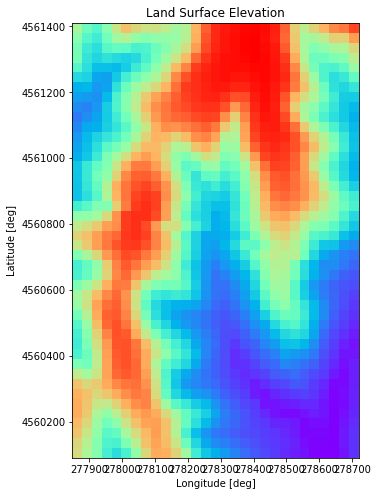

In [40]:
## RTG files are typically in the *input* vs. output directory
long_name = 'Land Surface Elevation'
rtg_filename = site_prefix + '_DEM.rtg'
rtg = rtg_files.rtg_file()
OK = rtg.open_file( rtg_filename )
if not(OK):
    print('Could not open RTG file.')
print('Byte swap needed =', rtg.byte_swap_needed())
print('Reading grid from RTG file...')
grid   = rtg.read_grid( VERBOSE=True )
extent = rtg.get_bounds()
# For Treynor, the extent is in UTM eastings and northings
print('extent =', extent)
print('min(grid), max(grid) =', grid.min(), grid.max())
print('Finished.')
rtg.close_file()
print()

tfvis.show_grid_as_image( grid, long_name, extent=extent,
                          cmap='rainbow', stretch='hist_equal',
                          # cmap='rainbow', stretch='linear',
                          xsize=8, ysize=8, dpi=None)

## Show a Grid from a Grid Stack in a TF netCDF file  <a id="show_nc1_C"></a>

var_names in netCDF file =
['time', 'X', 'Y', 'Q']
long_name = volumetric_discharge
var_name  = Q
var_units = m^3/s
n_grids   = 168
extent = 
[277850.358, 278720.358, 4560090.42, 4561410.42]
grid shape = (44, 29)
min(grid)  = 0.0
max(grid)  = 13.900598



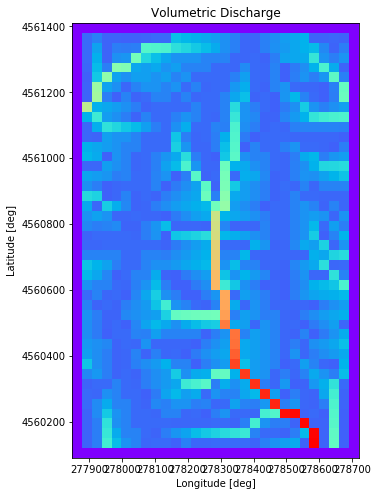

In [41]:
nc_file = case_prefix + '_2D-Q.nc'
# nc_file = case_prefix + '_2D-d-flood.nc'

(grid, long_name, extent) = tfvis.read_grid_from_nc_file(nc_file, time_index=84)
print()

tfvis.show_grid_as_image( grid, long_name, extent=extent,
                          cmap='rainbow', stretch='power', p=0.3,
                          xsize=8, ysize=8, dpi=None)

## Show a Grid from Grid Stack in an RTS File  <a id="show_rts1_C"></a>

Byte swap needed = True
rts.number_of_grids()  = 168.0
Reading one grid from RTS file... 
  time_index = 84
extent = [277850.358, 278720.358, 4560090.42, 4561410.42]
min(grid), max(grid) = 0.0 13.900598
Finished.



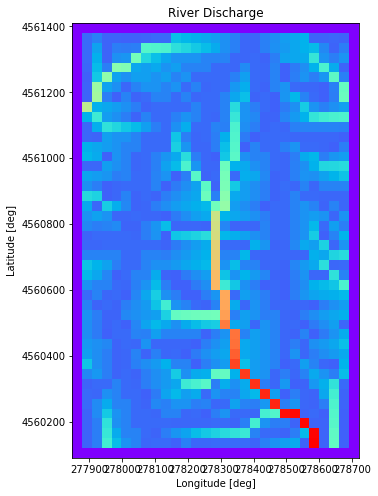

In [37]:
long_name = 'River Discharge'
rts_filename = case_prefix + '_2D-Q.rts'
rts = rts_files.rts_file()
OK = rts.open_file( rts_filename )
if not(OK):
    print('Could not open RTS file.')
print('Byte swap needed =', rts.byte_swap_needed())
n_grids = rts.number_of_grids()
print('rts.number_of_grids()  =', n_grids)
print('Reading one grid from RTS file... ')
time_index = int(n_grids / 2)
print('  time_index =', time_index )
grid   = rts.read_grid( time_index )   # alias to get_grid()
extent = rts.get_bounds()
print('extent =', extent)
print('min(grid), max(grid) =', grid.min(), grid.max())
print('Finished.')
rts.close_file()
print()

tfvis.show_grid_as_image( grid, long_name, extent=extent,
                          cmap='rainbow', stretch='power', p=0.3,
                          # a=1, b=2, p=0.5,
                          xsize=8, ysize=8, dpi=None)

## Create a Set of Image Files from a TF Grid Stack (netCDF) <a id="stack2im_C"></a>

In [5]:
png_dir3 = output_dir + '/' + 'png_files3'
if not(os.path.exists( png_dir3 )): os.mkdir( png_dir3)

nc_file = case_prefix + '_2D-Q.nc'
# nc_file = case_prefix + '_2D-d-flood.nc'

tfvis.save_grid_stack_as_images( nc_file, png_dir3, extent=extent,
                                 xsize=8, ysize=8, dpi=192, REPORT=True)


Creating images from grid stack in nc_file:
  June_20_67_2D-Q.nc
  var name  = Q
  long name = volumetric_discharge
  n_grids   = 100
This may take a few minutes.
Working...
Finished saving 100 images to PNG files.


## Make a Movie from a Set of Image Files  <a id="ims2movie_C"></a>

In [6]:
fps = 10  # frames per second
mp4_file = case_prefix + '_Q_Grid_Movie.mp4'
tfvis.create_movie_from_images( mp4_file, png_dir3, fps=fps, REPORT=True)


Creating movie from 100 PNG files.
Working...
Finished creating movie, MP4 format.
  June_20_67_Q_Grid_Movie.mp4



## Plot a TF Time Series <a id="ts_plot_C"></a>

var_names in netCDF file =
['time', 'Q_34_16', 'Q_32_16', 'Q_37_19', 'Q_26_14', 'Q_30_15', 'Q_0_0']
var longitudes =
[277850.49133333337, 277850.49133333337, 277850.51633333333, 277850.47466666665, 277850.483, 277850.358]
var latitudes =
[4560090.703333333, 4560090.6866666665, 4560090.7283333335, 4560090.636666667, 4560090.67, 4560090.42]



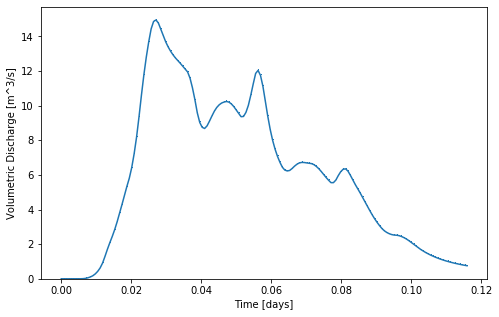

In [42]:
nc_file = case_prefix + '_0D-Q.nc'
# nc_file = case_prefix + '_0D-d-flood.nc'

tfvis.plot_time_series(nc_file, output_dir=output_dir, marker=',',
                       REPORT=True, xsize=8, ysize=5)


## Plot One Profile in a TF Profile Series  <a id="prof_plot_C"></a>

In [43]:
nc_file = case_prefix + '_1D-q.nc'
# nc_file = case_prefix + '_1D-p.nc'
# nc_file = case_prefix + '_1D-K.nc'
# nc_file = case_prefix + '_1D-v.nc'

tfvis.plot_z_profile(nc_file, time_index=10,
                     output_dir=output_dir, marker=',',
                     REPORT=True, xsize=8, ysize=5)


FileNotFoundError: [Errno 2] No such file or directory: b'June_20_67_1D-q.nc'

## Create a Set of Image Files from a TF Profile Series  <a id="ps_images_C"></a>

In [18]:
png_dir4 = output_dir + '/' + 'png_files4'
if not(os.path.exists( png_dir4 )): os.mkdir( png_dir4)

nc_file = case_prefix + '_1D-q.nc'
ymin = 0.0
ymax = 0.5
# nc_file = case_prefix + '_1D-p.nc'
# nc_file = case_prefix + '_1D-K.nc'
# nc_file = case_prefix + '_1D-v.nc'
# ymin = None
# ymax = None

# Set ymin and ymax to make them same for all plots.
tfvis.save_profile_series_as_images(nc_file, png_dir=png_dir4,
                   ymin=ymin, ymax=ymax,    # (same for all plots)
                   # ymin=None, ymax=None,  # (auto for each plot)
                   marker=',', REPORT=True,
                   xsize=8, ysize=5, dpi=192)


Creating images from z profiles in nc_file:
  June_20_67_1D-q.nc
  var name  = q_34_16
  long_name = soil_water_content
  Number of profiles = 200
This may take a few minutes.
Working...
Finished saving 200 images to PNG files.


## Make a Movie from a TF Profile Series  <a id="ps_movie_C"></a>

In [19]:
fps = 20  # frames per second
mp4_file = case_prefix + '_Profile_Movie_q.mp4'
# mp4_file = case_prefix + '_Profile_Movie_p.mp4'
# mp4_file = case_prefix + '_Profile_Movie_K.mp4'
# mp4_file = case_prefix + '_Profile_Movie_v.mp4'

tfvis.create_movie_from_images( mp4_file, png_dir4, fps=fps, REPORT=True)


Creating movie from 200 PNG files.
Working...
Finished creating movie, MP4 format.
  June_20_67_Profile_Movie_q.mp4



## Play the Movie in the Notebook  <a id="play_movie_C"></a>

An extension that allows you to play MP4 movie files in JupyterLab is
[<b>available on GitHub</b>](https://github.com/jupyterlab/jupyterlab-mp4)
(by Ian Rose of the JupyterLab organization) and can be installed with
these commands.
    
``` bash
% conda activate tfvis
% conda install jupyterlab
% jupyter labextension install @jupyterlab/mp4-extension
```

<b>Note:</b> The last command is from a pull-request on the extension's github repo.
Using the command: "jupyter labextension install jupyterlab-mp4" results in the
following error message:<br>
An error occured.
ValueError: "jupyterlab-mp4" is not a valid npm package

In [44]:
# import os.path   # (not needed now)
# from IPython.display import Audio, Image, YouTubeVideo
from IPython.display import Video

# help(Video)    # (uncomment to learn more about Video)

In [11]:
#--------------------------------------------------------------------
# Note:  Choosing the video window dimensions.  If the movie was
#        created with size (8" x 5"), then its aspect ratio is 5/8.
#        To maintain this aspect ratio, set the width and height
#        in the call to Video() that have this same aspect ratio.
#        For example, width=640, height=400 => AR = 400/640 = 5/8,
#        and width=560, height=350  => AR = 350/560 = 5/8.
#--------------------------------------------------------------------

#---------------------------------------------------------------
#  Now, it also works to specify the full path to the MP4 file
#  Make sure to user "Users" vs. "User" here.   :)
#---------------------------------------------------------------
mp4_file2 = output_dir + '/' + mp4_file
print(mp4_file2)

#---------------------------------------------
# Option to embed the video in the notebook
# but this can result in large notebook file
#---------------------------------------------
Video( mp4_file2, embed=True, width=640, height=400)

# For some reason, it doesn't work without "embed=True"
# Video( mp4_file, width=600, height=300)

#-------------------------------------------------------------
#  You can just use the name of the MP4 file if it is in the
#  the same directory as your notebook (.ipynb file).
#  (e.g. /Users/peckhams/Jupyter, in this case)
#-------------------------------------------------------------
# mp4_file = 'Test2_Profile_Movie.mp4'
# Video( mp4_file, width=600, height=450)


#--------------------------------------------------------------------
#  You could use os.path.relpath() or os.path.abspath(), but that
#  doesn't appear to be necessary now.  You could specify the path
#  relative to the the location of the notebook.
#--------------------------------------------------------------------
## mp4_file = os.path.relpath( mp4_file, start='/Users/peckhams/Jupyter')
## print(mp4_file)
## print(mp4_file)
## Video( mp4_file, embed=True, width=600, height=300)

## mp4_file = '../../..' + mp4_file
## mp4_file = os.path.abspath( mp4_file )


## Appendix 1: Installing TopoFlow in a conda Environment  <a id="setup_C"></a>

To run this Jupyter notebook, it is recommended to use Python 3.7 from an Anaconda distribution and to install the required Python packages in a conda environment called <b>tf36</b>.  This prevents conflicts with other Python packages you may have installed.
The Anaconda distribution includes many packages from the
[<b>Python Standard Library</b>](https://docs.python.org/3/library/).

First, download the TopoFlow 3.6 package from GitHub repo "topoflow36" at:
<b>https://github.com/peckhams/topoflow36</b>.
Copy or unzip the package into some directory on your computer.  Let's refer to this full path as TF36_DIR.  e.g. TF36_DIR = /Users/peckhams/Dropbox/TopoFlow_3.6

Installing TopoFlow 3.6 with pip causes most of its dependencies to be installed automatically.  However, if you want to run the growing collection of Jupyter notebooks (such as this one) that highlight TopoFlow functionality, you will also need to install the
[<b>nb_conda</b>](https://docs.anaconda.com/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/) package, and optionally the <b>jupyterlab</b> package (see below).
In addition, some of the new TopoFlow utilities (e.g. regrid.py and visualize.py) require the
[<b>gdal</b>](https://pypi.org/project/GDAL/) and
[<b>matplotlib</b>](https://matplotlib.org/) packages.
Simply type the following commands at an OS prompt after installing Anaconda and downloading TopoFlow.

``` bash
% conda update -n base conda
% conda create --name tf36
% conda activate tf36
% conda list
% conda install nb_conda
% conda install gdal
% conda install matplotlib
% conda install imageio
% pip install imageio-ffmpeg  (an imageio extension)
% cd TF36_DIR
% pip install -e .   (-e is the editable/developer option)
```

<b>Note:</b>  The <b>pip</b> package manager is used to install TopoFlow 3.6, since it is not available as a conda package.  (It gets installed when you install <b>nb_conda</b>.) However, like conda, pip will install a package and its dependencies into the currently active conda environment, as explained
[<b>in these docs</b>](https://docs.conda.io/projects/conda/en/4.6.1/user-guide/tasks/manage-pkgs.html#installing-non-conda-packages).  If you switch to another environment with <b>conda activate envname</b>, you can confirm that topoflow (or cfunits, gdal, netcdf4, etc.) is not there with <b>conda list</b>. 

<b>Note:</b>  Some of the new TopoFlow utilities use a Python package version of [<b>GDAL</b>](https://pypi.org/project/GDAL/).  At the time of this writing, installing <b>gdal</b> from the <b>conda-forge </b> with <i>conda install -c conda-forge gdal</i> did not work.

<b>Note:</b> The netCDF4 package will be installed as a TopoFlow dependency.

#### <b>Conda Environments</b>

Note that <b>conda</b> is the name of the package manager for the popular Anaconda Python distribution.  One feature of conda is support for multiple environments, which are isolated from one another.  When you install Anaconda, an environment called <b>base</b> is created for you and a base set of commonly-used Python packages are installed there.  However, you can (and should!) create additional, named environments and install different sets of Python packages into them without worrying about potential conflicts with packages in other environments.  Type <b>conda env list</b> to list your available environments.  You can switch to one of your other environments using the command <b>conda activate envname</b>.  (Replace "envname" with the name of an environment.) You can switch back to the base environment with the command <b>conda deactivate</b>.  It is better not to install new packages into the base environment.  See the online conda documentation on [<b>Managing Environments</b>](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) for more information.

It is always a good idea to update conda itself before creating new environments and installing packages in them. The "-n" flag is followed by the name of the environment to update, and the "-c" flag is followed by the name of the <b>channel</b> from which to get packages.  A channel is a collection of Python packages that are provided and maintained by some group.  The word "defaults" refers to
[<b>Anaconda's own collection</b>](https://docs.anaconda.com/anaconda/packages/pkg-docs/), while
[<b>conda-forge</b>](https://conda-forge.org/feedstocks/)
refers to another popular collection and the GitHub organization that maintains it.  Many Python packages are available from both of these channels.  (However, the ipyleaflet and pydap  packages are currently not available in the Anaconda collection.) When you are installing several packages into an environment, the potential for installation problems seems to be less if you get them all from the same channel.  Keep in mind that packages you install will likely depend on many other Python packages, so there is a potential for conflicts, usually related to different package versions.  Using conda environments helps to mitigate against this and helps with <b>reproducibility</b>.

Once you've switched to an environment with <b>conda activate envname</b>, you can type <b>conda list</b> to see a list of packages.  If you do this right after you create a new environment you will see that it contains no packages.  If you do this right after installing each package above you will see that:

<ul>
    <li>Installing <b>nb_conda</b> triggers installation of <b>nb_conda_kernels</b>,
    <b>ipykernel</b> (5.3.0), <b>notebook</b> (6.0.3) and <b>traitlets</b>
    (4.3.3), among many others. 
    <li>Installing <b>gdal</b> triggers installation of #######.
    <li>Installing <b>matplotlib</b> triggers installation of ##########. 
    <li>Installing <b>imageio</b> triggers installation of ##########. 
</ul>

#### <b>Jupyter Notebook Extensions</b>

Note that <b>nb_conda</b> is installed first above, and triggers installation of <b>nb_conda_kernels</b> along with <b>notebook</b>.  This is important as it makes your Jupyter notebook app aware of your conda environments and available in the app as "kernels".
Anaconda provides a helpful page on the
[<b>Jupyter Notebook Extensions</b>](https://docs.continuum.io/anaconda/user-guide/tasks/use-jupyter-notebook-extensions/).
That page also explains how you can enable or disable these extensions individually. The command <b>jupyter nbextension list</b> shows you the extensions that are installed and whether they are enabled.  If you run the <b>jupyter notebook</b> or <b>jupyter lab</b> command in an environment that has <b>nb_conda_kernels</b> installed (see below), you will have the ability to associate one of your available conda environments with any new notebook you create.  Different environments give rise to different <b>kernels</b> in Jupyter, and the kernel name includes the environment name, e.g. <b>Python \[conda env:balto\]</b>.  The kernel name is displayed in the upper right corner.  Notebooks typically open with the "environment kernel" they were created with. However, there is a <b>Change Kernel</b> option in the <b>Kernel</b> menu in the Jupyter app menu bar. (After changing the kernel, you may need to choose <b>Restart</b> from the <b>Kernel</b> menu.

#### <b>Cloning a conda Environment</b>

If your notebook is working but then you want to import additional packages (possibly with many dependencies, and potential for problems), you can keep the first environment but clone it with
<b><i>conda create --name clonename --copy --clone envname</i></b>,
and then install the additional packages in the clone.  This way, you can switch to the new environment's kernel and try to run your notebook, but if you run into any problems you can easily revert back to the original environment and functionality.

<b>Note:</b> Setting the "--copy" flag installs all packages using copies instead of hard or soft links.  This is necessary to avoid problems when using <b>pip</b> together with <b>conda</b> as described [<b>on this page</b>](https://stackoverflow.com/questions/43879119/installing-tensorflow-in-cloned-conda-environment-breaks-conda-environment-it-wa).

#### <b>Running Notebooks in the Jupyter Notebook App</b>

When you want to run the notebook, type <b>conda activate tf36</b> (at an OS command prompt) to activate this environment.  Then change to the directory that contains this notebook and type <b>jupyter notebook</b>.  By default, this folder is called <b>Jupyter</b> and is in your home directory.  In the app, choose this notebook by name, "TopoFlow_Getting_Started.ipynb", and make sure to choose the kernel called:  <b>Python \[conda env:balto\]</b>.  See the References section at the end for more info.

#### <b>Running Notebooks in the JupyterLab App</b>

The
[<b>JupyterLab</b>](https://jupyterlab.readthedocs.io/en/stable/index.html)
app is a cool, new successor to the Notebook app and offers many additional features.  If you want to use this notebook in JupyterLab, you need to install one more Python package, as follows.

``` bash
% conda activate tf36
% conda install jupyterlab
```

You launch the JupyterLab app by typing <b>jupyter lab</b> instead of <b>jupyter notebook</b>.  To quit, choose <b>Logout</b> or <b>Shutdown</b> from the app's <b>File</b> menu.

Finally, choose <b>TopoFlow_Getting_Started.ipynb</b> in Jupyter Notebook or Jupyter Lab.
In Jupyter Lab, choose the kernel:  Python [conda evn:tfvis].  Whenever you want to run this notebook, you will then need to switch to this "tfvis" environment with the command: "conda activate tfvis".

#### <b>JupyterLab Extensions</b>

The Jupyter project provides documentation on
[<b>JupyterLab Extensions</b>](https://jupyterlab.readthedocs.io/en/stable/user/extensions.html)
which add capabilities to JupyterLab.  For example, after installing jupyterlab (see just above), if you want to use the <b>ipywidgets</b> and <b>ipyleaflet</b> Python packages, you need to install two extensions, as follows:
```
% conda activate tf36
% jupyter labextension install jupyter-leaflet
% jupyter labextension install @jupyter-widgets/jupyterlab-manager
```
However, you should only install trusted extensions, due to security concerns, as explained in the documentation.  Third-party extensions pose a potential security risk.  An extension that allows you to play MP4 movie files in JupyterLab is
[<b>available on GitHub</b>](https://github.com/jupyterlab/jupyterlab-mp4)
(by Ian Rose of the JupyterLab organization)
and can be installed with the command:
```
% jupyter labextension install @jupyterlab/mp4-extension
```
<b>Note:</b> This command is from a pull-request on the extension's github repo.
Using the command: "jupyter labextension install jupyterlab-mp4" results in the
following error message:<br>
An error occured.
ValueError: "jupyterlab-mp4" is not a valid npm package

As of May 27, 2020, JupyterLab has added an experimental <b>Extension Manager</b> which can be enabled by choosing Settings > Enable Extension Manager in the app.